In [1]:
import numpy as np

def non_maximum_supression(heat_map, threshold, merge_distance):
    points = np.array(np.nonzero(heat_map > threshold)).T

    collision = True
    while collision:
        collision = False
        result_points = []
        for i in range(len(points)):
            merge = False
            for j in range(i+1, len(points)):
                dif = points[i] - points[j]
                dist = dif[0]*dif[0] + dif[1]*dif[1]
                if dist <= merge_distance**2: 
                    merge=True
                    collision = True
                    break
            if not merge: # ... if i doesn't collide, add it. If it does, ignore it -> j will get added instead
                result_points.append(points[i])
        points = result_points
    return points

In [2]:
from pathlib import Path
from piecharts.data.dataset import PiechartDataset
from piecharts.nn.models.config import TrainConfig
from piecharts.nn.models.smp_models import PSMModel
import torch

dir = Path('../models') / 'GOOD'

config_path = dir / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainConfig.parse_raw(json_config)


model = PSMModel(config.model, True).cuda()
state_dict = torch.load(dir / 'epoch30.h5')
model.load_state_dict(state_dict)
dataset = PiechartDataset(Path("../data") / "raw", "val_and_test", "val")



/home/davton/miniconda3/envs/datathon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from piecharts.utils.area_utils import get_sectors
from piecharts.utils.image import pad_tensor_to_divisible_by_N
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame(columns=["id", "predicted_percentages"])

with torch.no_grad():
    for i,(x,_) in tqdm(enumerate(dataset), total = len(dataset)):
        id = int(dataset.dataframe.iloc[i].filename[6:-4])

        x = x[None].cuda()
        x = pad_tensor_to_divisible_by_N(x, 32)

        y_pred = model(x)
        y_softmax = torch.nn.functional.softmax(y_pred, dim=1)

        arc_points = non_maximum_supression(y_softmax[0,1].cpu().numpy(), 0.5, 2)
        centers = non_maximum_supression(y_softmax[0,2].cpu().numpy(), 0.5, 2)
        
        all_distances = []

        for arc_point in arc_points:
            for center_point in centers:
                all_distances.append((sum((arc_point - center_point)**2))**(1/2))

        if len(all_distances) != 0:
            min_val = int(min(all_distances))
            threshold = min_val*1.5

            centers_cropped = []
            for center in centers:
                if int(center[0]) not in range(min_val, x.shape[-2] - min_val):
                    continue
                if int(center[1]) not in range(min_val, x.shape[-1] - min_val):
                    continue
                centers_cropped.append(center)

            arcs_ok = [False]*len(arc_points)
            centers_ok = [False] * len(centers_cropped)
            for i, arc_point in enumerate(arc_points):
                for j, center_point in enumerate(centers_cropped):
                    dist = int(sum((arc_point - center_point)**2)**(1/2))
                    if dist < threshold:
                        arcs_ok[i] = True
                        centers_ok[j] = True

            arcs_clean = [point for point, ok in zip(arc_points, arcs_ok) if ok]
            centers_clean = [point for point, ok in zip(centers, centers_ok) if ok]
        else:
            arcs_clean = arc_points
            centers_clean = centers

        if len(centers_clean) == 0 or len(arcs_clean) == 0:
            secs = []
        else:
            secs = get_sectors([(x[1], x[0]) for x in centers_clean], [(x[1], x[0]) for x in arcs_clean], x.shape[-2])
        df.loc[len(df)] = {'id': id, 'predicted_percentages': secs}

  0%|          | 14/20000 [00:00<05:57, 55.93it/s]/media/davton/Data/dev/PieChartsDatathon/src/piecharts/utils/area_utils.py:170: RuntimeWarning: invalid value encountered in scalar divide
  percentages = [100 * area / total_area for area in areas]
  0%|          | 36/20000 [00:00<07:35, 43.84it/s]/media/davton/Data/dev/PieChartsDatathon/src/piecharts/utils/area_utils.py:170: RuntimeWarning: invalid value encountered in scalar divide
  percentages = [100 * area / total_area for area in areas]
  0%|          | 56/20000 [00:01<06:23, 51.95it/s]/media/davton/Data/dev/PieChartsDatathon/src/piecharts/utils/area_utils.py:170: RuntimeWarning: invalid value encountered in scalar divide
  percentages = [100 * area / total_area for area in areas]
/media/davton/Data/dev/PieChartsDatathon/src/piecharts/utils/area_utils.py:170: RuntimeWarning: invalid value encountered in scalar divide
  percentages = [100 * area / total_area for area in areas]
/media/davton/Data/dev/PieChartsDatathon/src/piecharts

In [9]:
submission_df = pd.DataFrame({
    'id': df.id,
    'predicted_percentages': [str(lst) for lst in df.predicted_percentages]
})


In [10]:
submission_df.to_csv('initial_submission.csv', index=False)

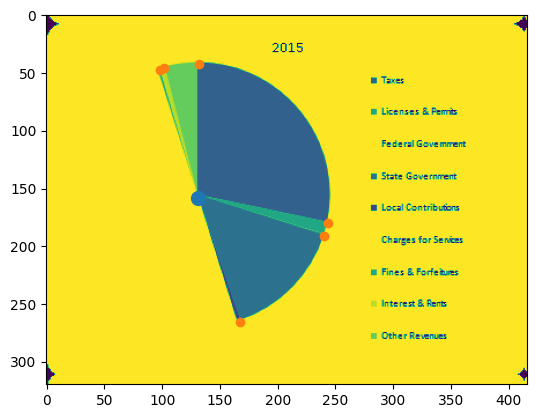

In [74]:
from matplotlib import pyplot as plt
plt.imshow(x.cpu()[0,0])
plt.plot([x[1] for x in centers_clean], [x[0] for x in centers_clean], 'o', markersize=10)
plt.plot([x[1] for x in arcs_clean], [x[0] for x in arcs_clean], 'o')

plt.show()

In [66]:
get_sectors([(x[1], x[0]) for x in centers_clean], [(x[1], x[0]) for x in arcs_clean], x.shape[-2])

[63.479477587095545, 36.520522412904455]

In [36]:
all_distances = []

for arc_point in arc_points:
    for center_point in centers:
        all_distances.append((sum((arc_point - center_point)**2))**(1/2))

min_val = int(min(all_distances))
threshold = min_val*1.5

centers_cropped = []
for center in centers:
    if int(center[0]) not in range(min_val, x.shape[-2] - min_val):
        continue
    if int(center[1]) not in range(min_val, x.shape[-1] - min_val):
        continue
    centers_cropped.append(center)

arcs_ok = [False]*len(arc_points)
centers_ok = [False] * len(centers_cropped)
for i, arc_point in enumerate(arc_points):
    for j, center_point in enumerate(centers_cropped):
        dist = int(sum((arc_point - center_point)**2)**(1/2))
        if dist < threshold:
            arcs_ok[i] = True
            centers_ok[j] = True

arcs_clean = [point for point, ok in zip(arc_points, arcs_ok) if ok]
centers_clean = [point for point, ok in zip(centers, centers_ok) if ok]


In [18]:
all_distances = []

for arc_point in arc_points:
    for center_point in centers:
        all_distances.append((sum((arc_point - center_point)**2))**(1/2))

min_val = min(all_distances)
threshold = min_val*1.5

arcs_ok = [False]*len(arc_points)
centers_ok = [False] * len(centers)
for i, arc_point in enumerate(arc_points):
    for j, center_point in enumerate(centers):
        dist = sum((arc_point - center_point)**2)**(1/2)
        if dist < threshold:
            arcs_ok[i] = True
            centers_ok[j] = True

arcs_clean = [point for point, ok in zip(arc_points, arcs_ok) if ok]
centers_clean = [point for point, ok in zip(centers, centers_ok) if ok]


In [15]:
all_distances

[270.1851217221259,
 519.1310046606733,
 271.0073799733136,
 269.0018587296378,
 50.00999900019995,
 275.80065264607333,
 49.64876634922564,
 287.9027613622349,
 48.25971404805462,
 291.547594742265]

In [12]:
all_distances

[array([154., 222.]),
 array([269., 444.]),
 array([154., 223.]),
 array([269.,   1.]),
 array([50.,  1.]),
 array([165., 221.]),
 array([47., 16.]),
 array([162., 238.]),
 array([ 5., 48.]),
 array([110., 270.])]

In [33]:
print(arc_points)
print(centers)

[array([126, 464]), array([192, 318]), array([481, 573])]
[array([321, 464])]


In [38]:
centers

[array([156, 170])]

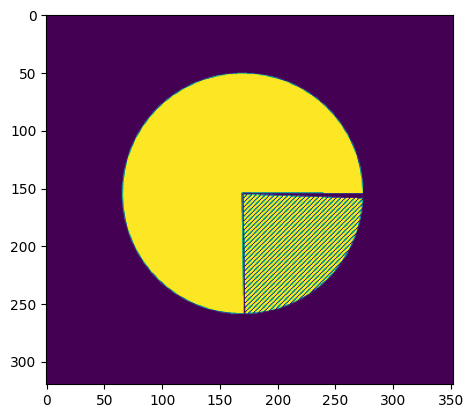

In [23]:
plt.imshow(x[0,0].cpu())